In [1]:
import matplotlib.pyplot as plt
import xarray as xr
from metpy.units import units
import metpy.calc as mpcalc
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import sklearn.cluster as cluster
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids 

In [2]:
'''
Define Model Parameters
'''
MODEL_DATE = '20230704'
MODEL_CYCLE = '12z'

# Define area of interest
LAT = 32.897480
LON = -97.040443

FORECAST_DATES = [(datetime.today() + timedelta(days=day)).strftime('%Y-%m-%d') 
                  for day in range(1, 16)]

In [3]:
base_url = f'https://nomads.ncep.noaa.gov/dods/gefs/gefs{MODEL_DATE}/gefs_pgrb2ap5_all_{MODEL_CYCLE}'

ds = xr.open_dataset(base_url, decode_times=True)

/Users/rhawthorne/miniconda3/envs/metpy/lib/python3.11/site-packages/xarray/coding/times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [4]:
t_max = ds.tmax2m.metpy.sel(lat=LAT, lon=360+LON, method='nearest') * units('K')

In [5]:
t_max = t_max.metpy.convert_units('degF')
t_max

Magnitude,[[nan 95.78176879882812 100.53852081298828 ... 101.21000671386719 96.35003662109375 89.73456573486328] [nan 96.19820404052734 100.7967529296875 ... 100.18344116210938 97.15088653564453 83.11277770996094] [nan 96.32174682617188 100.67969512939453 ... 102.25568389892578 100.84998321533203 91.49397277832031] ... [nan 95.22240447998047 100.3126449584961 ... 107.0932388305664 105.15772247314453 94.26373291015625] [nan 95.09001922607422 97.86901092529297 ... 107.14998626708984 104.62999725341797 95.39263153076172] [nan 94.88176727294922 99.10057830810547 ... 101.97959899902344 100.85503387451172 90.02290344238281]]
Units,degree_Fahrenheit


In [6]:
df = t_max.to_dataframe('temp')
df.dropna(inplace=True)
df.reset_index(inplace=True)
df

,ens,time,lat,lon,temp
0,1.0,2023-07-04 18:00:00,33.0,263.0,95.781769
1,1.0,2023-07-05 00:00:00,33.0,263.0,100.538521
2,1.0,2023-07-05 06:00:00,33.0,263.0,98.453918
3,1.0,2023-07-05 12:00:00,33.0,263.0,88.500420
4,1.0,2023-07-05 18:00:00,33.0,263.0,96.252647
...,...,...,...,...,...
1979,31.0,2023-07-19 12:00:00,33.0,263.0,91.939079
1980,31.0,2023-07-19 18:00:00,33.0,263.0,96.716377
1981,31.0,2023-07-20 00:00:00,33.0,263.0,101.979599
1982,31.0,2023-07-20 06:00:00,33.0,263.0,100.855034


In [7]:
# Only include rows with 00 UTC
# High temps usually occur in the 6 hours prior over the Americas
df = df[df['time'].dt.strftime('%H:%M:%S').str.contains('00:00:00')]

In [8]:
df.reset_index(drop=True, inplace=True)
df

,ens,time,lat,lon,temp
0,1.0,2023-07-05,33.0,263.0,100.538521
1,1.0,2023-07-06,33.0,263.0,100.702660
2,1.0,2023-07-07,33.0,263.0,100.746490
3,1.0,2023-07-08,33.0,263.0,101.652641
4,1.0,2023-07-09,33.0,263.0,103.598656
...,...,...,...,...,...
491,31.0,2023-07-16,33.0,263.0,106.326225
492,31.0,2023-07-17,33.0,263.0,97.682953
493,31.0,2023-07-18,33.0,263.0,105.281212
494,31.0,2023-07-19,33.0,263.0,103.548721


In [9]:
df_time = df.groupby(['time'])
last_forecast_timestep = df_time.get_group(FORECAST_DATES[1])[['temp']]

In [10]:
def calculate_elbow_cluster_number(data, min_clusters, max_clusters, metric='euclidean'):
    """
    Calculates the ideal number of clusters from k-medoids using the elbow method with a Pandas DataFrame as input.
    Creates a graph to visualize the within-cluster sum of squares (WCSS).
    
    Arguments:
    data -- The input data points as a Pandas DataFrame.
    max_clusters -- The maximum number of clusters to consider.
    metric -- The distance metric to be used (default: 'euclidean').
    
    Returns:
    The ideal number of clusters determined by the elbow method.
    """
    wcss = []  # Within-cluster sum of squares
    
    for n_clusters in range(min_clusters, max_clusters + 1):
        # Convert the DataFrame to a NumPy array
        data_array = data.values
        
        # Perform k-medoids clustering
        kmedoids = KMedoids(n_clusters=n_clusters, metric=metric)
        kmedoids.fit(data_array)
        
        # Compute the within-cluster sum of squares (WCSS)
        wcss.append(kmedoids.inertia_)
    
    print(wcss)
    # Calculate the differences in WCSS
    diff_wcss = np.diff(wcss)
    print(diff_wcss)
    
    # Find the ideal number of clusters based on the elbow point
    ideal_clusters = np.argmax(diff_wcss) + min_clusters  # Add min_clusters due to range start
    print(ideal_clusters)
    
    # Create a graph to visualize the within-cluster sum of squares (WCSS)
    plt.plot(range(min_clusters, max_clusters + 1), wcss, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.title('WCSS for K-Medoids Clustering')
    plt.show()
    
    return ideal_clusters

[20.499046, 17.188599, 15.914459, 15.210289]
[-3.3104477 -1.2741394 -0.7041702]
4


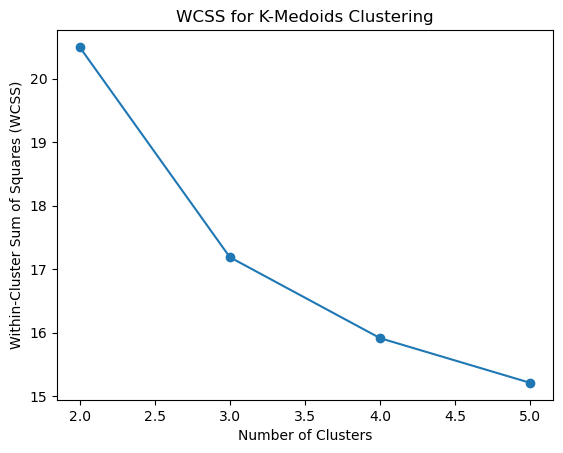

In [11]:
elbow_scr = calculate_elbow_cluster_number(last_forecast_timestep, 2, 5)

In [12]:
def calculate_cluster_number(data, min_clusters, max_clusters, metric='euclidean'):
    """
    Calculates a preferred number of clusters from k-medoids using the silhouette score with a Pandas DataFrame as input.
    Creates a graph to visualize the silhouette scores.
    
    Arguments:
    data -- The input data points as a Pandas DataFrame.
    max_clusters -- The maximum number of clusters to consider.
    metric -- The distance metric to be used (default: 'euclidean').
    
    Returns:
    The preferred number of clusters determined by the silhouette score.
    """
    silhouette_scores = []
    
    for n_clusters in range(min_clusters, max_clusters + 1):
        # Convert the DataFrame to a NumPy array
        data_array = data.values
        
        # Perform k-medoids clustering
        kmedoids = KMedoids(n_clusters=n_clusters, metric=metric)
        labels = kmedoids.fit_predict(data_array)
        
        # Compute the silhouette score
        silhouette_avg = silhouette_score(data_array, labels, metric=metric)
        silhouette_scores.append(silhouette_avg)
    
    # Find the preferred number of clusters based on the maximum silhouette score
    preferred_clusters = np.argmax(silhouette_scores) + min_clusters  # Add min_clusters due to range start
    
    # Create a graph to visualize the silhouette scores
    plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for K-Medoids Clustering')
    plt.show()
    
    return preferred_clusters

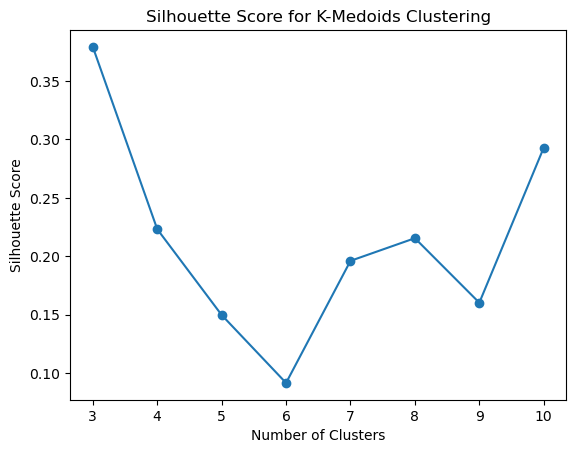

3

In [13]:
silhouette_scr = calculate_cluster_number(last_forecast_timestep, 3, 10)
silhouette_scr

In [14]:
# Either elbow_scr or silhouette_scr
number_clusters = silhouette_scr

In [15]:
cluster_centers_dict = {}

for date in FORECAST_DATES:
    single_forecast_date = df_time.get_group(date)
    p25 = single_forecast_date['temp'].quantile(.25)
    p50 = single_forecast_date['temp'].median()
    p75 = single_forecast_date['temp'].quantile(.75)
    kmedo = KMedoids(n_clusters=number_clusters, random_state=1)
    kmedo.fit(single_forecast_date[['temp']])
    cluster_centers = kmedo.cluster_centers_.flatten()
    cluster_centers = np.append(cluster_centers, p25)
    cluster_centers = np.append(cluster_centers, p50)
    cluster_centers = np.append(cluster_centers, p75)
    # Add the cluster centers to the dictionary with the date as the key
    cluster_centers_dict[date] = cluster_centers

# Create a DataFrame from the dictionary
df_cluster_centers = pd.DataFrame.from_dict(cluster_centers_dict, orient='index')
df_cluster_centers = df_cluster_centers.rename_axis('date').reset_index()

# Rename last few columns to add p25, p50, p75
col_names = list(df_cluster_centers.columns)
p25_column = int(col_names[-3])
p50_column = int(col_names[-2])
p75_column = int(col_names[-1])
df_cluster_centers.rename(columns={p25_column: 'p25', p50_column: 'p50', p75_column: 'p75'}, 
                          inplace=True)

df_cluster_centers

,date,0,1,2,p25,p50,p75
0,2023-07-05,99.669060,98.941383,101.008018,99.263779,99.669060,100.815651
1,2023-07-06,99.793480,101.144585,98.870026,99.132545,99.988930,100.980366
2,2023-07-07,101.017906,99.506851,97.429993,98.505058,99.711143,100.933945
3,2023-07-08,100.081596,98.192612,103.082626,98.890297,100.081596,101.995499
4,2023-07-09,103.613426,101.258347,105.315651,101.864655,103.613426,104.873257
5,2023-07-10,104.838348,108.648300,101.331459,102.350937,104.782486,107.454384
6,2023-07-11,105.755272,101.479004,109.490013,102.262882,105.755272,108.936222
7,2023-07-12,100.425087,104.112152,109.386856,100.671757,104.043602,107.164925
8,2023-07-13,105.426888,110.280975,101.228790,101.841881,105.316528,108.645664
9,2023-07-14,106.582153,109.490013,100.946831,102.454208,106.167198,107.200600


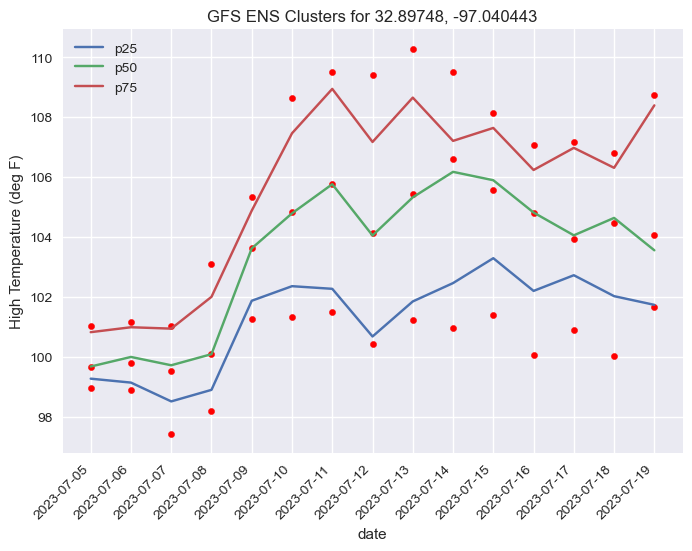

In [16]:
plt.style.use('seaborn-v0_8')
for n in range(0, number_clusters):
    ax = df_cluster_centers.plot.scatter(x='date', y=n, color='red', ax=plt.gca(),
                        title=f'GFS ENS Clusters for {LAT}, {LON}')
df_cluster_centers.plot.line(y='p25', ax=plt.gca())
df_cluster_centers.plot.line(y='p50', ax=plt.gca())
df_cluster_centers.plot.line(y='p75', ax=plt.gca())
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("High Temperature (deg F)")
plt.show()